# this file is used to preprocess the raw data

##Define some basic functions:

In [3]:
# -- coding: utf-8 --
#1.load libraries
#from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
import scipy.ndimage
from tqdm import tqdm #progress tube
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage import measure, morphology
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi

import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML

    
import warnings #remove warnings
warnings.filterwarnings("ignore")





# functions
def make_mask(center,diam,z,width,height,spacing,origin): #只显示结节
    '''
Center : 圆的中心 px -- list of coordinates x,y,z
diam : 圆的直径 px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+10)
    print "v_diam: ", v_diam
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)



def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))


#
# Helper function to get rows in data frame associated 
# with each file



def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)


#
# The locations of the nodes
def normalize(image, MIN_BOUND=-1000.0, MAX_BOUND=400.0):
    """数据标准化"""
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image
    #---数据标准化
    
    
def set_window_width(image, MIN_BOUND=-1000.0, MAX_BOUND=400.0):
    """设置窗宽"""
    image[image > MAX_BOUND] = MAX_BOUND
    image[image < MIN_BOUND] = MIN_BOUND
    return image
    #---设置窗宽   


#remove all the useless 

In [2]:
def get_segmented_lungs(im, show=False):  
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    im = im.copy()
    if show == True:
        plot = plt.subplot()
        plot.imshow(im, cmap=plt.cm.bone)
        plt.show()
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -230
    if show == True:
        plot = plt.subplot()
        plot.imshow(binary, cmap=plt.cm.bone) 
        plt.show()
    cleared = clear_border(binary)

    if show == True:
        plot = plt.subplot()
        plot.imshow(cleared, cmap=plt.cm.bone) 
        print "3"
        plt.show()

    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if show == True:
        plot = plt.subplot()
        plot.imshow(label_image, cmap=plt.cm.bone)
        plt.show()
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0

    binary = label_image > 0
    if show == True:
        plot = plt.subplot()
        plot.imshow(binary, cmap=plt.cm.bone)
        plt.show()
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if show == True:
        plot = plt.subplot()
        plot.imshow(binary, cmap=plt.cm.bone)
        plt.show()
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if show == True:
        plot = plt.subplot()
        plot.imshow(binary, cmap=plt.cm.bone)
        plt.show()
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if show == True:
        plot = plt.subplot()
        plot.imshow(binary, cmap=plt.cm.bone)
        plt.show()
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = -1000
    
    
    if show == True:
        plot = plt.subplot()
        plot.imshow(im, cmap=plt.cm.bone)
        plt.show()
    
    im[im < -420] = -1000
    if show == True:
        plot = plt.subplot()
        plot.imshow(im, cmap=plt.cm.bone)
        plt.show()
    
    return im

def plot_3d(image, threshold=-1000):   
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]    
    #print len(measure.marching_cubes(p, threshold))
    verts, faces, a, b = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

#####
# remove the two biggest vessels in the lung
#####
def filt_vessels(ct_scan):
    selem = ball(2)
    print selem

    segmented_ct_scan0 = ct_scan.copy()

    segmented_ct_scan = segmented_ct_scan0.copy()
    segmented_ct_scan[segmented_ct_scan >= -420] = 1
    segmented_ct_scan[segmented_ct_scan < -420] = 0

    binary = binary_closing(segmented_ct_scan, selem)
    label_scan = label(binary, neighbors=4, connectivity = 4) 
    #label_scan = label(segmented_ct_scan, neighbors=4) 

    rr =  regionprops(label_scan)
    areas = [r.area for r in rr]
    areas.sort()
    print areas[-6:-1]
    print "area len = ", len(areas)

    for r in rr:
        max_x, max_y, max_z = 0, 0, 0
        min_x, min_y, min_z = 1000, 1000, 1000

        rds = r.coords

        for c in rds:
            max_z = max(c[0], max_z)
            max_y = max(c[1], max_y)
            max_x = max(c[2], max_x)

            min_z = min(c[0], min_z)
            min_y = min(c[1], min_y)
            min_x = min(c[2], min_x)
        if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
            for c in rds:
                segmented_ct_scan0[c[0], c[1], c[2]] = -1000
        #else:
        #    index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))
    return segmented_ct_scan0

Read in pictures and associate it with pixel files

    # Mask the places of the ct_scan outside the nodule 

In [6]:
#2.1 read in the csv file
luna_path = 'data/'
luna_subset_path = luna_path + 'sample/'
file_list = glob(luna_subset_path + "*.mhd")
file_list = ['/home/izm/work/fjj/data/train_subset00/LKDS-00026.mhd']
df_node = pd.read_csv(luna_path + 'csv/train/' + 'annotations.csv')
out_path = 'output/'

#4.1 将数据关联至csv
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
#df_node.head(5)

print file_list
#print df_node

#raw_input('press entre to continue output')


for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0:                      # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane

        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        print origin, spacing
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([50,height,width], dtype=np.float32)
            masks = np.ndarray([50,height,width], dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            print "v_center = ", v_center
            #clip to get the slices in the centre places
            ll = int(v_center[2])-25
            hh = int(v_center[2])+25
            for i, i_z in enumerate(np.arange(ll, hh).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                print "----------------------------------"
                print i, i_z
                print "----------------------------------"
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
                        
            #np.save(os.path.join(out_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            #np.save(os.path.join(out_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)
            print img_array.shape, imgs.shape
            break


  0%|          | 0/1 [00:00<?, ?it/s]

['/home/izm/work/fjj/data/train_subset00/LKDS-00026.mhd']
[-175.   -163.1  -282.33] [ 0.625  0.625  0.625]
v_center =  [ 412.  130.  192.]
----------------------------------
0 167
----------------------------------
v_diam:  16
----------------------------------
1 168
----------------------------------
v_diam:  16
----------------------------------
2 169
----------------------------------
v_diam:  16
----------------------------------
3 170
----------------------------------
v_diam:  16
----------------------------------
4 171
----------------------------------
v_diam:  16
----------------------------------
5 172
----------------------------------
v_diam:  16
----------------------------------
6 173
----------------------------------
v_diam:  16
----------------------------------
7 174
----------------------------------
v_diam:  16
----------------------------------
8 175
----------------------------------
v_diam:  16
----------------------------------
9 176
----------------------------

100%|██████████| 1/1 [00:05<00:00,  5.64s/it]

----------------------------------
41 208
----------------------------------
v_diam:  16
----------------------------------
42 209
----------------------------------
v_diam:  16
----------------------------------
43 210
----------------------------------
v_diam:  16
----------------------------------
44 211
----------------------------------
v_diam:  16
----------------------------------
45 212
----------------------------------
v_diam:  16
----------------------------------
46 213
----------------------------------
v_diam:  16
----------------------------------
47 214
----------------------------------
v_diam:  16
----------------------------------
48 215
----------------------------------
v_diam:  16
----------------------------------
49 216
----------------------------------
v_diam:  16
(477, 512, 512) (50, 512, 512)


Make a masking of binary value and do some plotting

1190
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
(477, 512, 512)
-384


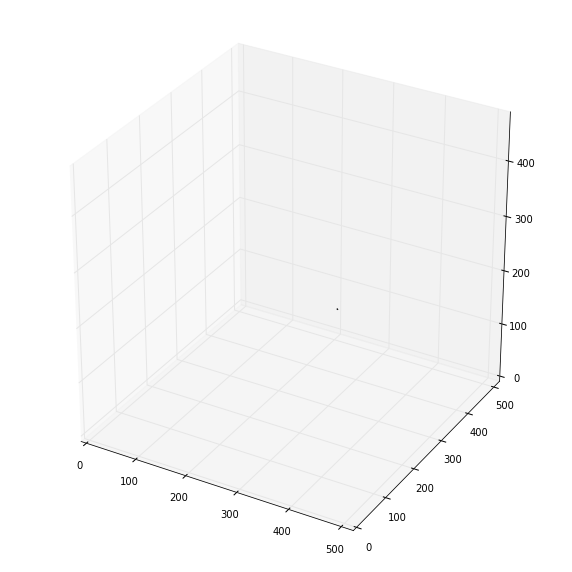

KeyboardInterrupt: 

In [17]:

#segmented_ct_scan0 = ct_scan.copy()
segmented_ct_scan0 = img_array.copy()
print np.max(segmented_ct_scan0[i])
for i in range(0, img_array.shape[0]):    
    if i >=  ll and i < hh:
        print i
        for j in range(512):
            for k in range(512):
                if masks[i-ll][j][k] == 0:                
                    segmented_ct_scan0[i][j][k] = -1000
    else:
        segmented_ct_scan0[i][:][:] = -1000
        
print   segmented_ct_scan0.shape


#segmented_ct_scan0[segmented_ct_scan0 < -320] = -1000
print np.max(segmented_ct_scan0)
plot_3d(segmented_ct_scan0, -400)


    
raw_input() 
for i in range(ll, hh):
    plot = plt.subplot()
    print i, np.max(segmented_ct_scan0[i])
    plot.imshow(segmented_ct_scan0[i], cmap=plt.cm.bone)
    #plot.imshow(img_array[i], cmap=plt.cm.bone)
    plt.show()


Segment the lung's space from the scans

  0%|          | 0/1 [00:00<?, ?it/s]

['/home/izm/work/fjj/data/train_subset00/LKDS-00026.mhd']


100%|██████████| 1/1 [00:48<00:00, 48.26s/it]


[[[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]

 [[0 0 1 0 0]
  [0 1 1 1 0]
  [1 1 1 1 1]
  [0 1 1 1 0]
  [0 0 1 0 0]]

 [[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
[3536, 4736, 5049, 18657, 93473]
area len =  23790


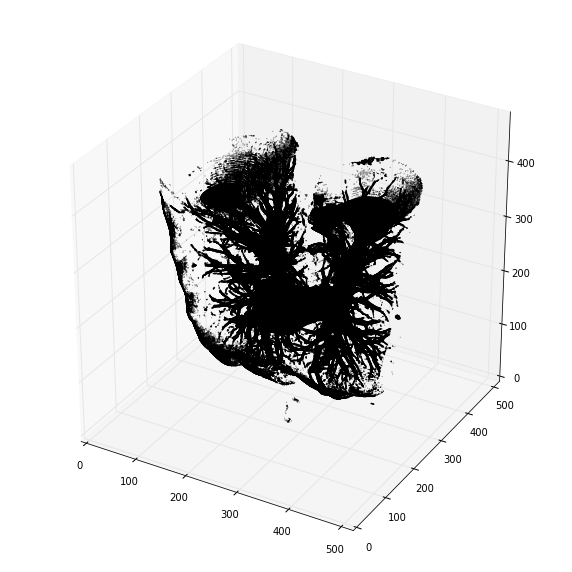

In [18]:

def mask_trainset(file_list):
    print file_list

    for fcount, img_file in enumerate(tqdm(file_list)):
        itk_img = sitk.ReadImage(img_file)
        nms = img_file.split('/')
        name = nms[-1]
        img_array = sitk.GetArrayFromImage(itk_img) 	# indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        	#heightXwidth constitute the transverse plane
        mask_array = []
        for i in range(num_z):
            mask_array.append(get_segmented_lungs(img_array[i]))
        res = np.array(mask_array, np.int16)
    #np.save(mask_out_path + name, res)
    return res, img_array



#file_list = glob(train_set_path + "*.mhd")
file_list = ['/home/izm/work/fjj/data/train_subset00/LKDS-00026.mhd']
mask_out_path = '/home/izm/work/fjj/data/masked/msk_'

ct_scan, origin = mask_trainset(file_list)

pure = filt_vessels(ct_scan)
plot_3d(ct_scan, -450)

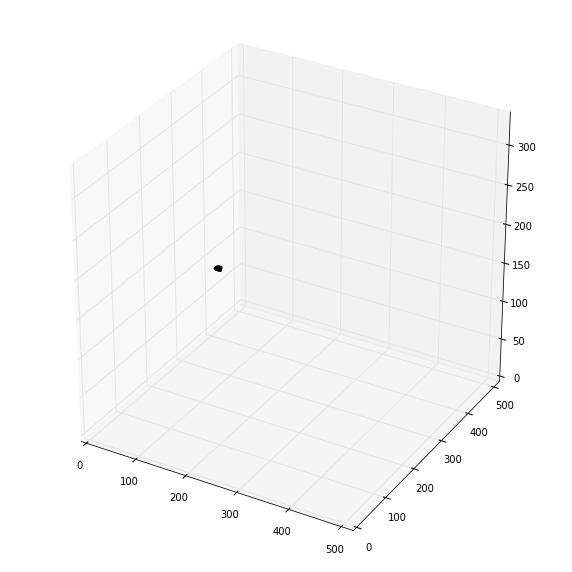

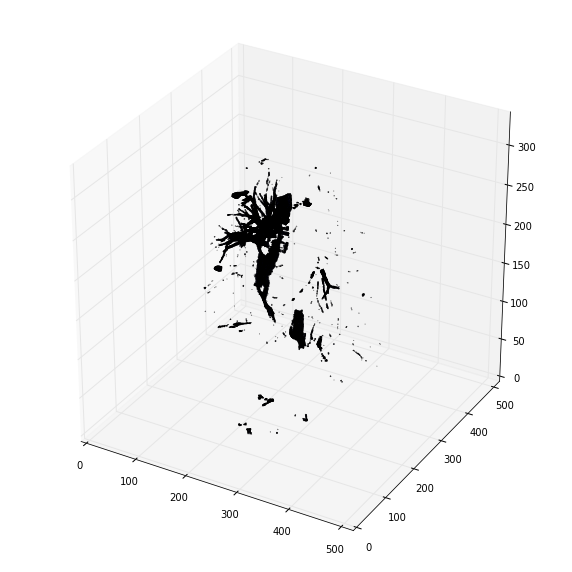

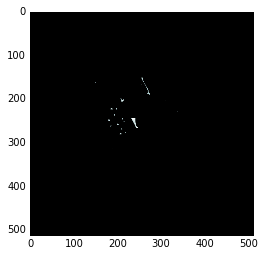

--------------------


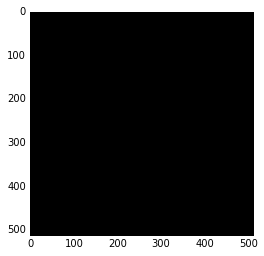

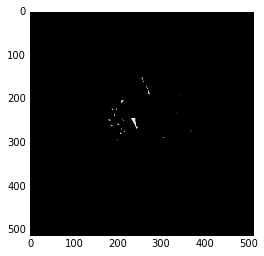

--------------------


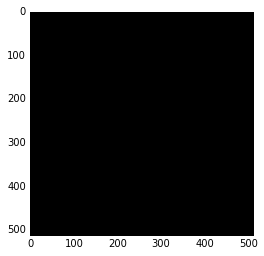

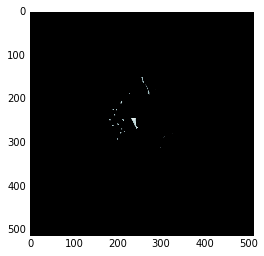

--------------------


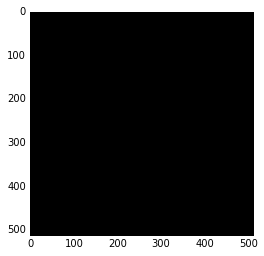

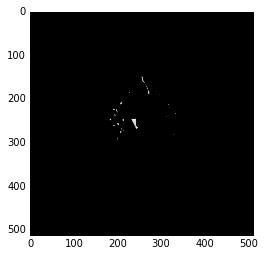

--------------------


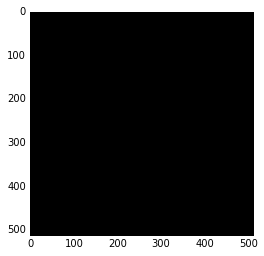

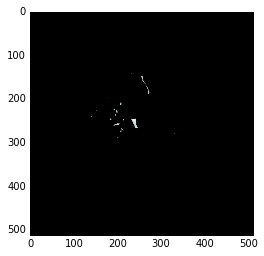

--------------------


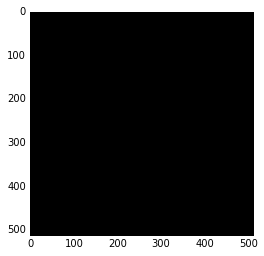

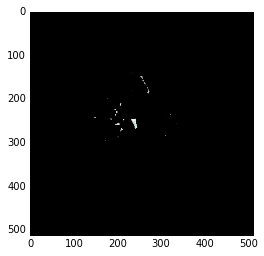

--------------------


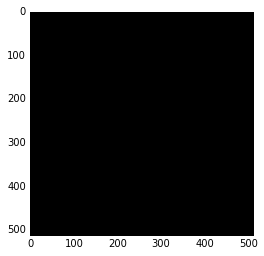

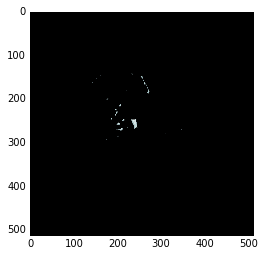

--------------------


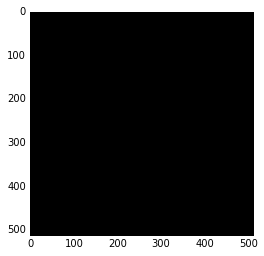

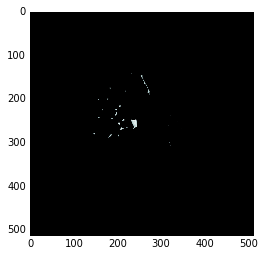

--------------------


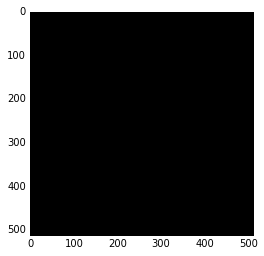

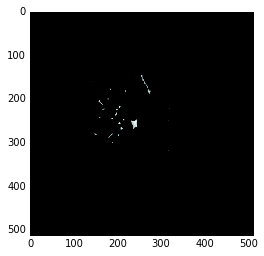

--------------------


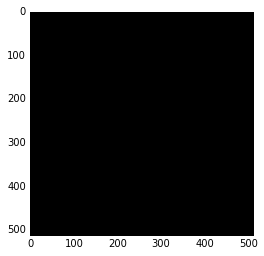

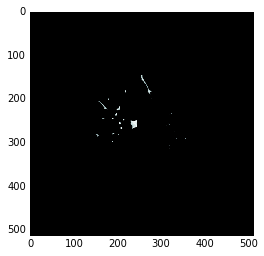

--------------------


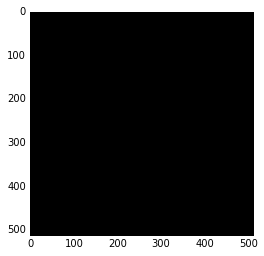

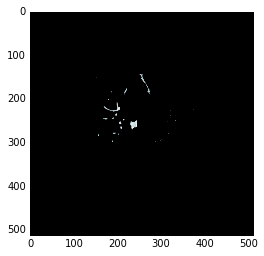

--------------------


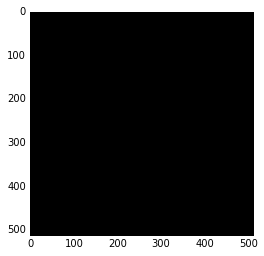

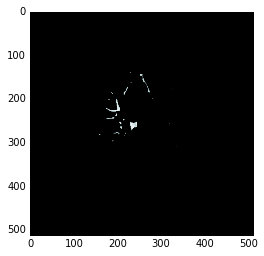

--------------------


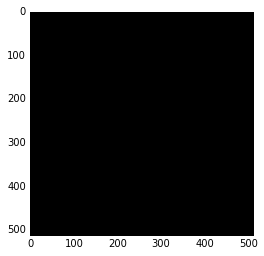

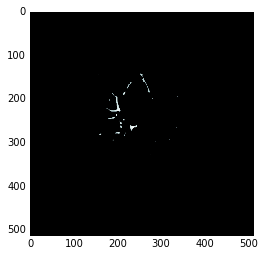

--------------------


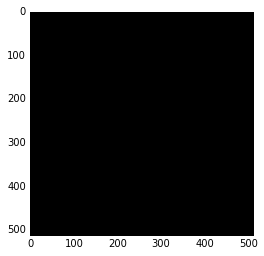

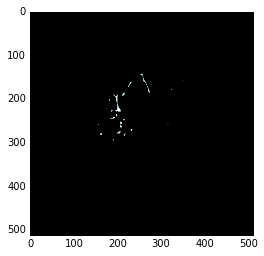

--------------------


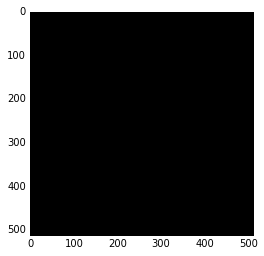

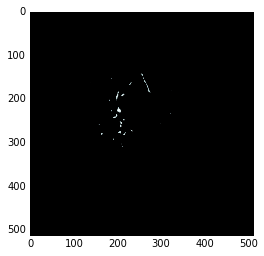

--------------------


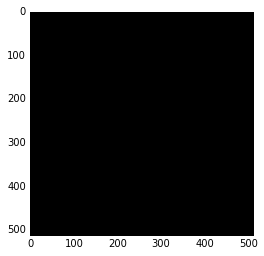

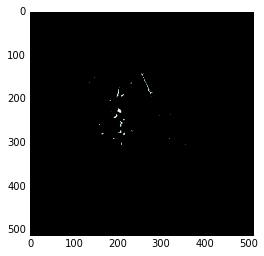

--------------------


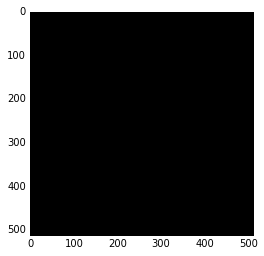

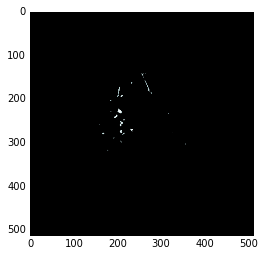

--------------------


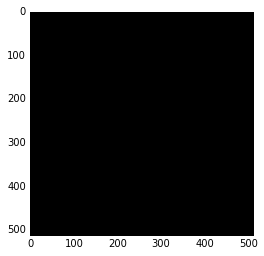

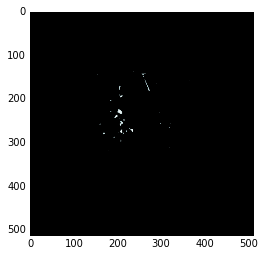

--------------------


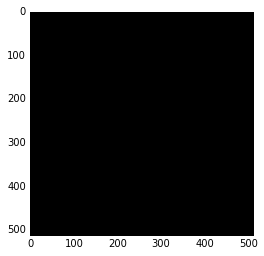

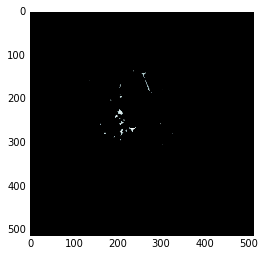

--------------------


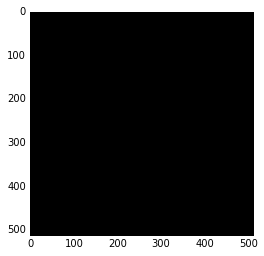

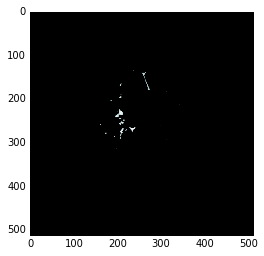

--------------------


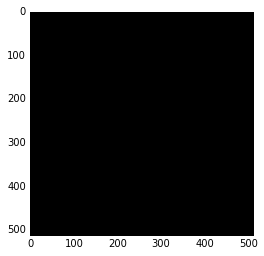

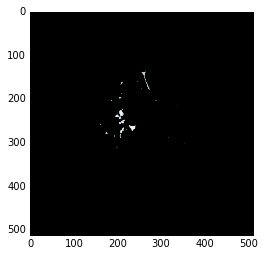

--------------------


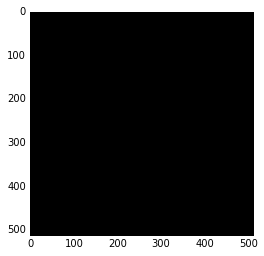

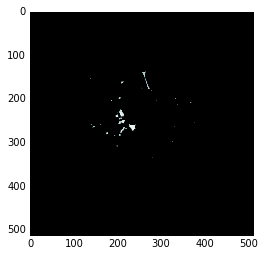

--------------------


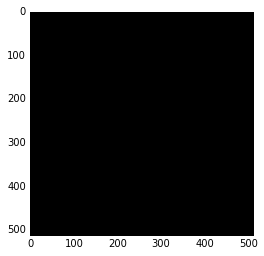

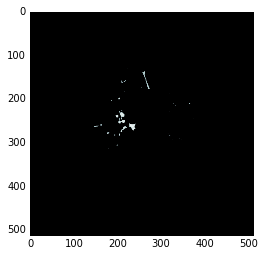

--------------------


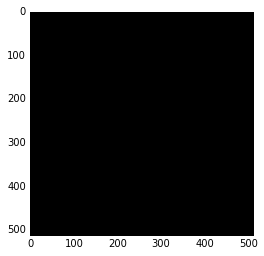

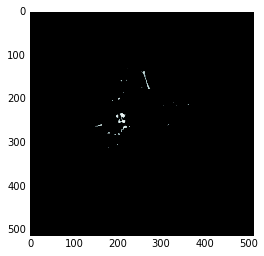

--------------------


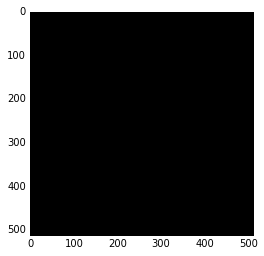

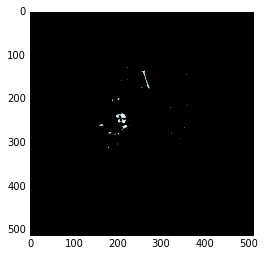

--------------------


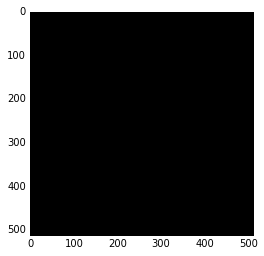

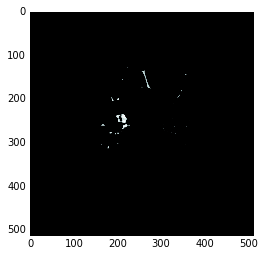

--------------------


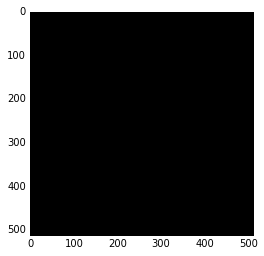

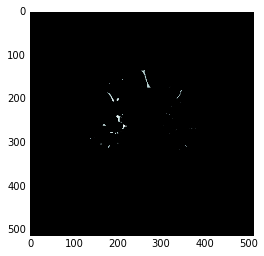

--------------------


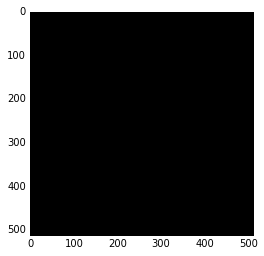

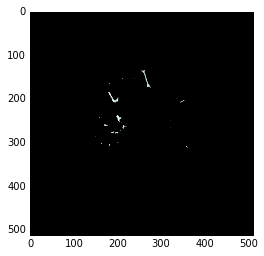

--------------------


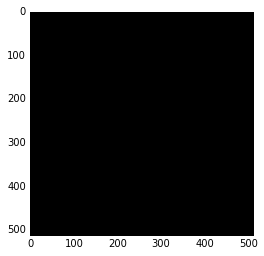

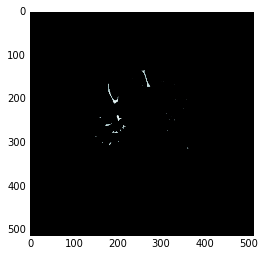

--------------------


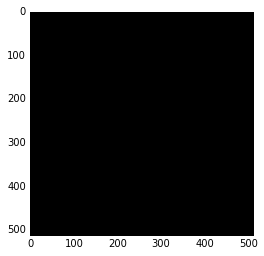

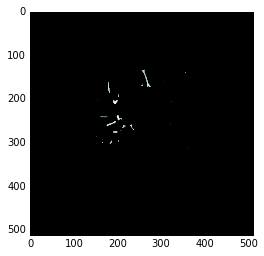

--------------------


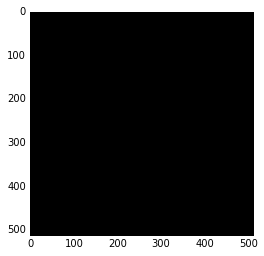

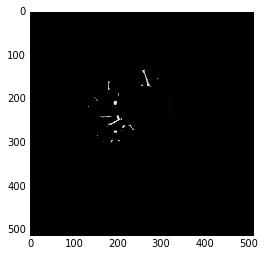

--------------------


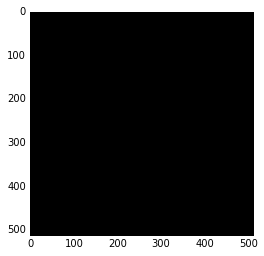

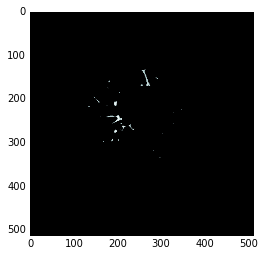

--------------------


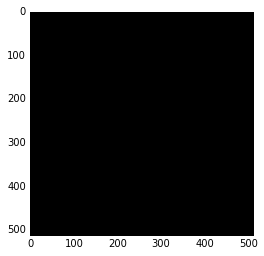

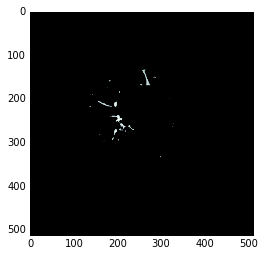

--------------------


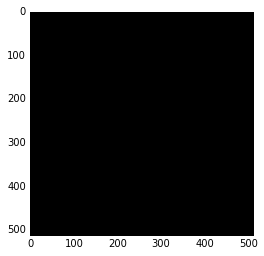

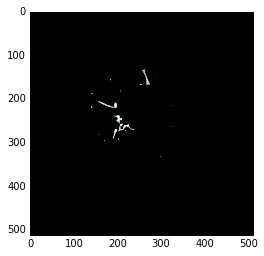

--------------------


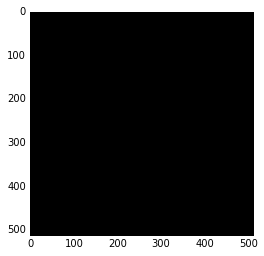

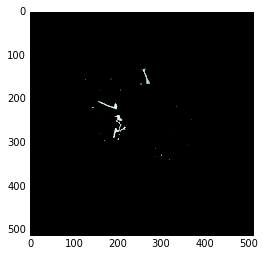

--------------------


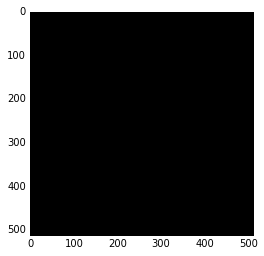

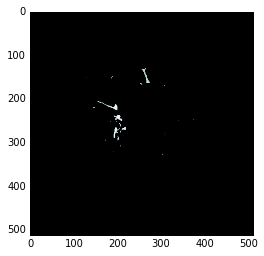

--------------------


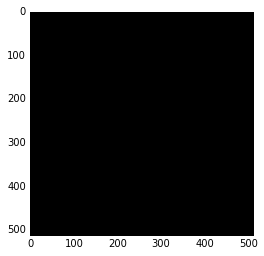

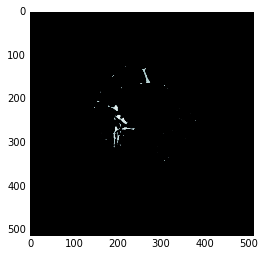

--------------------


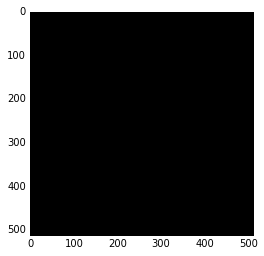

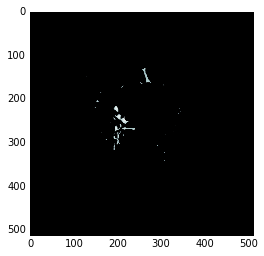

--------------------


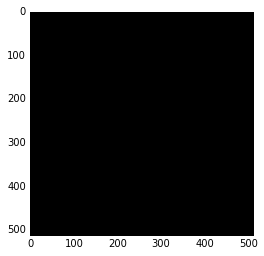

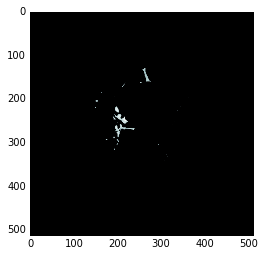

--------------------


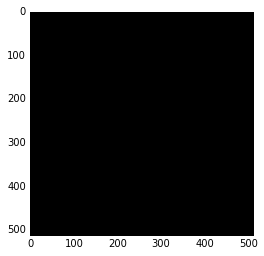

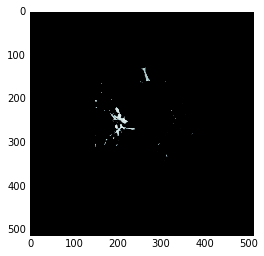

--------------------


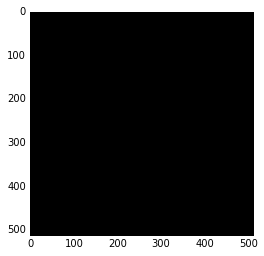

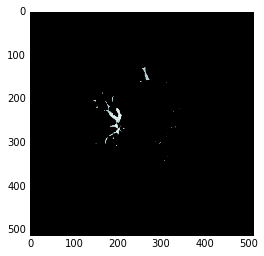

--------------------


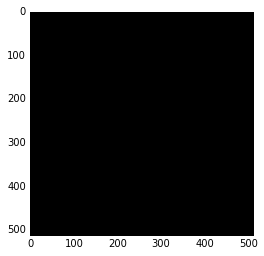

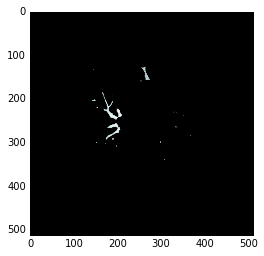

--------------------


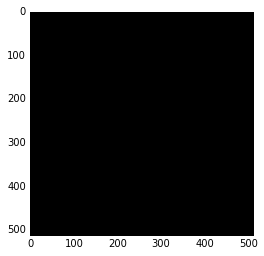

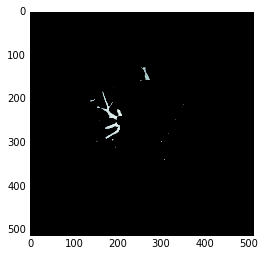

--------------------


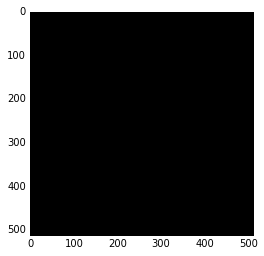

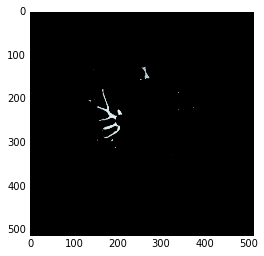

--------------------


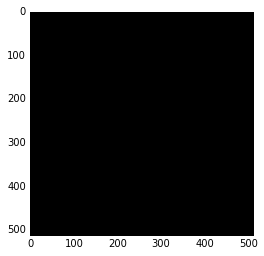

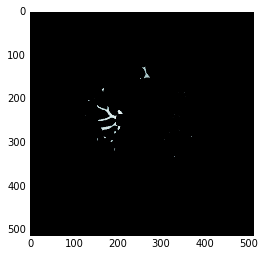

--------------------


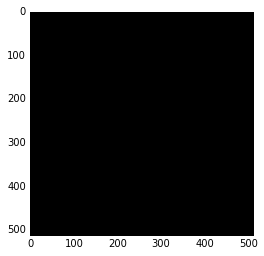

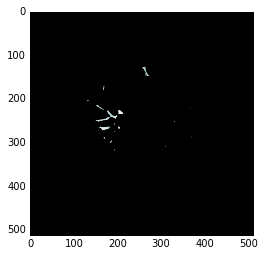

--------------------


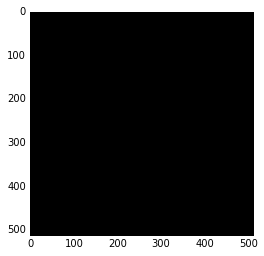

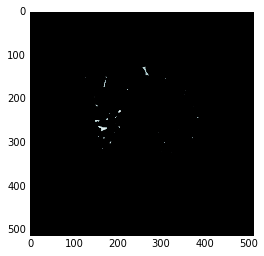

--------------------


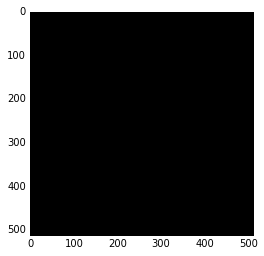

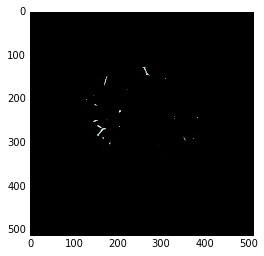

--------------------


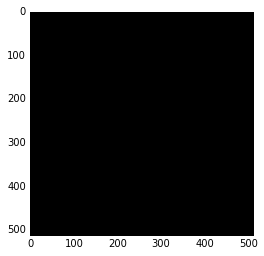

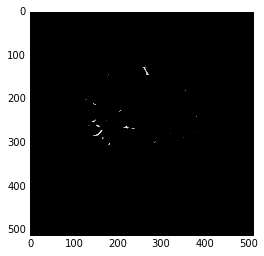

--------------------


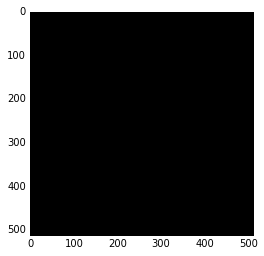

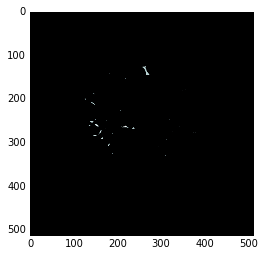

--------------------


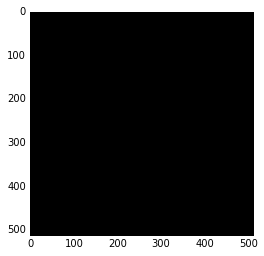

(334, 512, 512)


In [96]:
'''
r i in range(0, ct_scan.shape[0], 10):
    plot = plt.subplot()
    plot.imshow(ct_scan[0+i], cmap=plt.cm.bone)
    plt.show()
'''
#ct_scan, origin = mask_trainset(file_list)
#pure = filt_vessels(ct_scan)

plot_3d(segmented_ct_scan0, -200)
plot_3d(pure, -200)
#print ct_scan.shape
#raw_input()

for i in range(80, 130):
    plot = plt.subplot()
    plot.imshow(pure[i], cmap=plt.cm.bone)
    plt.show()
    print '--------------------'
    plot = plt.subplot()
    plot.imshow(segmented_ct_scan0[i], cmap=plt.cm.bone)
    plt.show()



print pure.shape

After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.
Now useless

In [30]:
#segmented_ct_scan = segmented_ct_scan0[100:130]
-

[[[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]

 [[0 0 1 0 0]
  [0 1 1 1 0]
  [1 1 1 1 1]
  [0 1 1 1 0]
  [0 0 1 0 0]]

 [[0 0 0 0 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
(325, 512, 512)
[1367, 1910, 2366, 4691, 117299]
area len =  7942


After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.

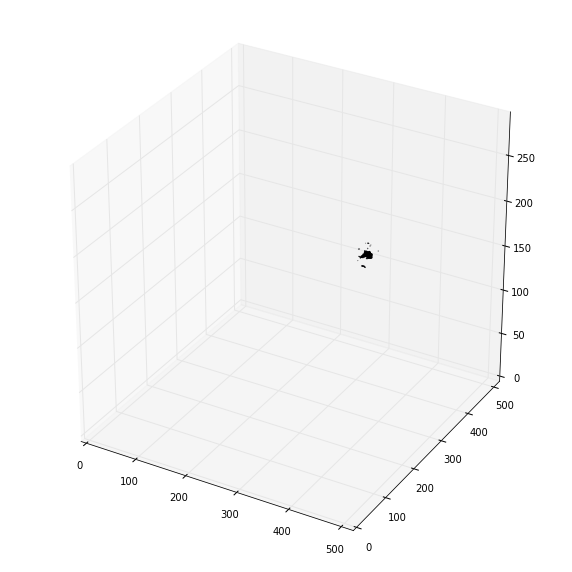

(291, 512, 512)


In [6]:

    
'''
for i in range(3):
    plot = plt.subplot()
    plot.imshow(imgs[i], cmap=plt.cm.bone)
    plt.show()
    
    plot = plt.subplot()
    plot.imshow(segmented_ct_scan0[143+i], cmap=plt.cm.bone)
    plt.show()   

    plot = plt.subplot()
    plot.imshow(masks[i], cmap=plt.cm.bone)
    plt.show()
    
for i in range(40):
    plot = plt.subplot()
    plot.imshow(ct_scan[110+i], cmap=plt.cm.bone)
    plt.show() 
  '''

#print segmented_ct_scan.shape
plot_3d(segmented_ct_scan0, 0)
print segmented_ct_scan0.shape

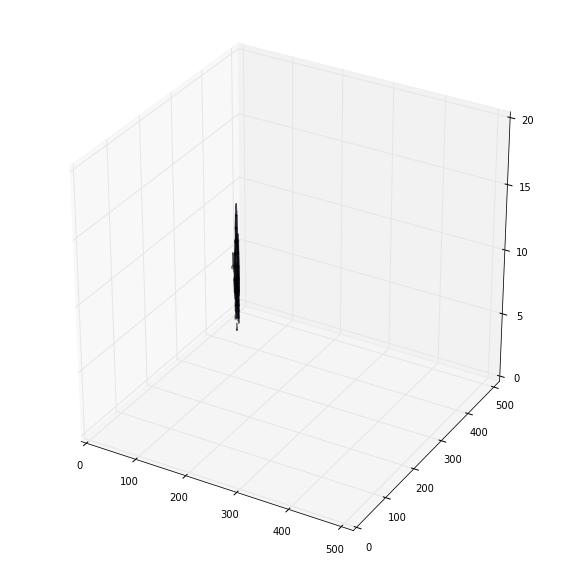

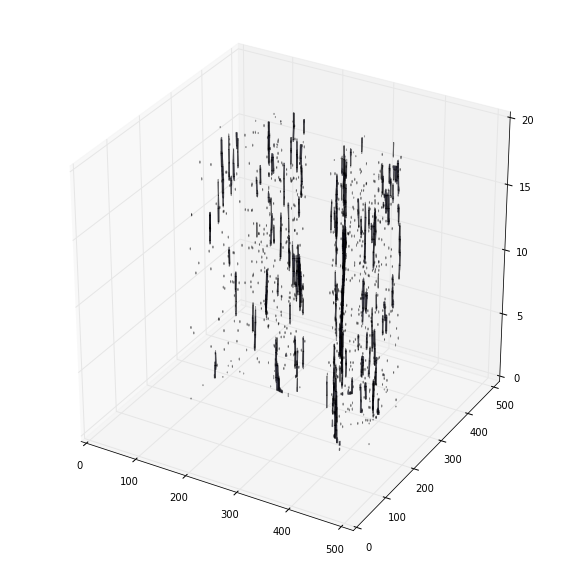

KeyboardInterrupt: 

In [15]:

#print img_array.shape
file_name = "LKDS-00020.mhd-1.npy"
lb_path = "/media/izm/Normal/FJJ/lb-1-1000/unet-lb-" + file_nm
input_path = "/media/izm/Normal/FJJ/in-1-1000/unet-in-" + file_nm

scan = np.load(lb_path)
plot_3d(scan, 0) 
scan = np.load(input_path)
plot_3d(scan, -400) 


raw_input()

for i in range(512):
    for j in range(512):
        reshp[i][j][0] = imgs[0][i][j]
        reshp[i][j][1] = imgs[1][i][j]
        reshp[i][j][2] = imgs[2][i][j]

plot = plt.subplot()
plot1 = plt.subplot()
gg = imgs[2]#reshp[:,:,0]
gg1 = reshp[:,:,1]
print gg1.shape, gg.shape
plot.imshow(gg, cmap=plt.cm.bone)
plot1.imshow(gg1, cmap=plt.cm.bone)
plt.show()

